# EVALUATION NOTEBOOK

### Effect of Prefilters
The dataset was transcribed with two different prefilters.
paired differences of the f-scores are shown as violinplot and boxplots

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

def printRow(data,prefilter="RP",alphabet="majmin"):
    text = f"{prefilter} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)


print(f"----------Table of results------------")
rp_text = "RP &"
median_text = "Median &"
header = "prefilter & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    rp = utils.getFscoreResults("../results/prefilter_rp.hdf5",alphabet,False)
    median = utils.getFscoreResults("../results/prefilter_median.hdf5",alphabet, False)
    printRow(rp,"RP",alphabet)
    printRow(median,"Median",alphabet)
    print("\\midrule")

    # plot paired difference
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        deltas.append([100*(x-y) for x,y in zip(rp[dset],median[dset])])
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    fig.savefig(f"../latex/figures/prefilter_delta_f_{alphabet}.png")
    ax.set_ylabel("delta F-score in %")
    # wilcoxon test
    print("-----Wilcoxon test for paired samples SEVENTHS-------")
    print("dataset & N & z & p & r \\\\")
    print("\\toprule")
    for i,dset in enumerate(["beatles","rwc\_pop","rw","queen","combined"]):
        N,p,z,r = utils.wilcoxonTest(deltas[i])
        if p < 0.001:
            print(f"{dset} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
        else:    
            print(f"{dset} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")


### Study on Source Separation
Vocals, drums were removed seperately with a hybrid transformer source separation network (demucs) to enhance the chroma.</br>
After seperating the drums, the vocals were again removed from the remaining signal.



In [ ]:
def printHeader():
    print(f"----------Table of results------------")
    header = "separation & scheme &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        if dset == "rwc_pop":
            header += "rwc\_pop & "
        else:
            header += dset +" &"
    header = header[:-1] + "\\\\"
    print(header)

def printRowFscore(data,method="none",alphabet="majmin"):
    text = f"{method} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def printRowTtest(data,pair="none",alphabet="majmin"):
    res = scipy.stats.wilcoxon(data,method='approx')
    N = len(data)
    p = res.pvalue
    z = res.zstatistic
    r = np.abs(z) / np.sqrt(N)
    if p < 0.001:
        print(f"{dset} & {pair} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
    else:    
        print(f"{dset} & {pair} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")

printHeader()
data = {}
for separation in ["none","vocals","drums","both"]:
    data[separation] = utils.getFscoreResults(f"../results/source_separation_{separation}",alphabet=alphabet)
    printRowFscore(data[separation],method=separation,alphabet=alphabet)

print("--------comparison pairs for wilcoxon test----")
# mix,vocals - mix,drums - mix, vocals/drums
row = "Comparison Pair"
for sep in ["vocals","drums","both"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        deltas.append([100*(x-y) for x,y in zip(data["none"][dset],data[separation][dset])])
        printRowTtest(deltas[-1],f"none, {sep}")
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    fig.savefig(f"../latex/figures/separation_{sep}_delta.png")
    

### NSGT-CQT  --- Tuning issues

In [ ]:
import numpy as np
import utils
import matplotlib.pyplot as plt
import dataloader
import librosa.display
import librosa
import nsgt

dset = "rwc_pop"
track_id = "RM-P002" 
time_interval = (5,15)
## Boys: 0105 -> blurry bass note  Tuning?
## Anna: 0103 
class interpolate:
    def __init__(self,cqt,Ls):
        from scipy.interpolate import interp1d
        self.intp = [interp1d(np.linspace(0, Ls, len(r)), r) for r in cqt]
    def __call__(self,x):
        try:
            len(x)
        except:
            return np.array([i(x) for i in self.intp])
        else:
            return np.array([[i(xi) for i in self.intp] for xi in x]) 
        
dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","none")
audiopath, annotationpath = dataset[track_id]
gt = utils.loadChordAnnotations(annotationpath)
sig = utils.loadAudiofile(audiopath,offset=time_interval[0],duration=time_interval[1]-time_interval[0])
estimated_tuning = librosa.estimate_tuning(y=sig,sr=22050)
f0 = librosa.tuning_to_A4(estimated_tuning)
print(f"f0={f0:0.1f} Hz")
midi2hz = lambda m,f0 : f0*(2.0**((m-69.0)/12.0))
fs = 22050
octaves = 6

fmin = midi2hz(24,f0) # C2
fmax = midi2hz(24 + 12*octaves,f0) # C6
bpo = 12
cq_nsgt = nsgt.CQ_NSGT(fmin,fmax, bpo,fs, len(sig))
# forward transform 
coeffs = cq_nsgt.forward(sig)

# interpolate CQT to get a grid
x = np.arange(0, len(sig), 64)
cqt = interpolate(map(np.abs, coeffs[2:]), len(sig))(x).T#

from scipy.fftpack import dct,idct
pitchgram_energy = cqt**2
pitchgram_energy = np.log(100 * pitchgram_energy + 1);  
vLogDCT = dct(pitchgram_energy, norm='ortho', axis=0);  
vLogDCT[:33,:] = 0 
vLogDCT[33,:] = 0.5 * vLogDCT[33,:]
pitchgram_energy = idct(vLogDCT, norm='ortho', axis=0)

chroma = np.zeros((12,pitchgram_energy.shape[1]),dtype=float)
for i in range(pitchgram_energy.shape[0]):
    index = i % 12
    chroma[(i+1) % 12,:] += pitchgram_energy[i,:]
chroma = chroma / np.sum(np.abs(chroma) + np.finfo(float).eps, axis=0)
fig,ax = plt.subplots(3,1,height_ratios=(10,1,5),figsize=(9,5))
t_cqt = time_interval[0] + x / fs
cqt_db = 20 * np.log10(cqt)
pmax = np.percentile(cqt_db, 99.99)
img = librosa.display.specshow(cqt_db,
                         ax=ax[0],x_coords=t_cqt,y_axis="cqt_hz",
                         fmin=fmin,fmax=fmax,x_axis="s",
                         cmap="viridis",vmax=pmax,vmin=pmax-80)
utils.plotChordAnnotations(ax[1],gt[0],gt[1],time_interval)
utils.plotChromagram(ax[2],t_cqt,chroma);

### CQT and pitchgram analysis

In [ ]:
import librosa
import numpy as np
import utils
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct
import dataloader
import librosa.display
import IPython.display as ipd
plt.ion()
dset = "rwc_pop"
track_id = "RM-P003" 

## Boys: 0105 -> blurry bass note  Tuning?
## Anna: 0103 

dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata","none")
audiopath, annotationpath = dataset[track_id] 
sig = utils.loadAudiofile(audiopath,duration=20)
gt = utils.loadChordAnnotations(annotationpath)

####### tuned CQT ############
midi_start = 36
octaves = 6
cqt_params = {"sr":22050,"bins_per_octave":36,"hop_length":1024,"fmin":librosa.midi_to_hz(midi_start)}

estimated_tuning = librosa.estimate_tuning(y=sig,sr=22050,bins_per_octave=36)
C = np.abs(librosa.vqt(sig,filter_scale=1,tuning=estimated_tuning,gamma=0,n_bins=octaves*36, **cqt_params))
C_db = 20 * np.log10(C+ np.finfo(float).eps)
pmax = np.percentile(C_db, 99.99)

time = (5,15)
fig,(ax0,ax1) = plt.subplots(2,1,height_ratios=(1,10),figsize=(6,4))
## librosa
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval=time)
img = librosa.display.specshow(C_db,
                         ax=ax1,y_axis="cqt_hz",x_axis="s",
                         vmax=pmax, vmin=pmax - 80,
                         cmap="viridis",**cqt_params)
ax1.set_xlim(time)
fig.tight_layout()

In [ ]:
## apply gaussian window function to deemphasize low frequent hum and overtones 
## centered around C4 +/- 15 note 
window=True
pitchgram_cqt = np.zeros((12*octaves,C.shape[1]),dtype=float)
pitchgram_cqt_windowed = np.zeros((12*octaves,C.shape[1]),dtype=float)
# pitchgram window function
for note in range(midi_start, midi_start+12*octaves):
    # weight and pick every third amplitude value
    pitchgram_cqt[note - midi_start,:] =  C[(note-midi_start)*3, :]
    pitchgram_cqt_windowed[note - midi_start,:] = np.exp(-(note-60)**2 / (2*15**2)) * C[(note-midi_start)*3,:] 
pitchgram_energy = pitchgram_cqt ** 2

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(6,4))
pitchgram_params = cqt_params
pitchgram_params["bins_per_octave"] = 12
librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt,ref=np.max),
                         ax=ax0,y_axis="cqt_hz",x_axis="s",cmap="viridis",**pitchgram_params)
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt_windowed,ref=np.max),
                         ax=ax1,x_axis="s",cmap="viridis",**pitchgram_params)
ax0.set_xlim(time)
ax1.set_xlim(time)
fig.colorbar(img);

In [ ]:
### Logarithmic Compression and Liftering 
eta = 100
nCRP = 33
if True:
    pitchgram_log = np.log(eta * pitchgram_energy + 1)
else:
    pitchgram_log = pitchgram_cqt
vLogDCT = dct(pitchgram_log, norm='ortho', axis=0);  
vLogDCT[:nCRP,:] = 0 
vLogDCT[nCRP,:] = 0.5 * vLogDCT[nCRP,:]
pitchgram_lift = idct(vLogDCT, norm='ortho', axis=0)

# pitch folding
crp = pitchgram_lift.reshape(octaves,12,-1) 
crp = np.sum(crp, axis=0)
crp = np.clip(crp,0,None) # clip negative values
crp = crp /np.sum(np.abs(crp) + np.finfo(float).tiny, axis=0) # apply manhattan norm

t_chroma = utils.timeVector(crp.shape[1],hop_length=cqt_params["hop_length"])

fig,((ax0,ax00),(ax1,ax11),(ax2,ax22),(ax3,ax33)) = plt.subplots(4,2,figsize=(7,7),width_ratios=(10,.1),height_ratios=(2,2,0.3,1))
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_log,ref=np.max),
                         ax=ax0,x_axis="s",y_axis="cqt_note",cmap="viridis",**pitchgram_params)
fig.colorbar(img,cax=ax00)
ax0.set_title("log compressed pitchgram (dB)")
img = librosa.display.specshow(pitchgram_lift,
                         ax=ax1,x_axis="s",y_axis="cqt_note",cmap="viridis",**pitchgram_params,vmin=-3,vmax=3)
fig.colorbar(img,cax=ax11)
ax1.set_title("liftered pitchgram")
for ax in [ax0,ax1]:
    ax.set_xlabel("")
ax2.set_title("CRP feature with annotations")
utils.plotChordAnnotations(ax2,gt[0],gt[1],time_interval=time)
ax22.set_axis_off()
ax2.set_xlabel("")
ax2.set_xticklabels([])
img = utils.plotChromagram(ax3,t_chroma,crp)
fig.colorbar(img,cax=ax33);
fig.tight_layout()

### Transsprition Results

In [ ]:
import matplotlib.pyplot as plt
from visualization import visualizationApp
%matplotlib inline
visualizationApp("../results");
plt.ioff(); # interactive mode off

#### Study on correlation vs inner product

----------Table of results------------
distance & scheme &beatles &rwc\_pop & rw &queen &combined \\
----Transcription Metadata----
source_separation=drums



10_-_I'm_Looking_Through_You
02_-_With_A_Little_Help_From_My_Friends
CD2_-_02_-_Yer_Blues
I've got a mail
Sweet Dreams
inner product & majmin &0.75$\pm$0.13 &0.78$\pm$0.14 &0.79$\pm$0.15 &0.73$\pm$0.17 &0.76$\pm$0.14 \\
correlation & majmin &0.77$\pm$0.14 &0.78$\pm$0.15 &0.81$\pm$0.13 &0.69$\pm$0.19 &0.78$\pm$0.15 \\
\midrule
-----Outliers majmin-------------
 Title   |  Inner  | Corr
11_-_I_Wanna_Be_Your_Man 0.78 0.58
07_-_Ticket_To_Ride 0.7 0.41
11_-_In_My_Life 0.62 0.86
12_-_Wait 0.83 0.53
13_-_If_I_Needed_Someone 0.5 0.79
01_-_Taxman 0.82 0.41
04_-_Love_You_To 0.68 0.47
01_-_Sgt 0.8 0.46
05_-_Fixing_A_Hole 0.68 0.32
08_-_Within_You_Without_You 0.77 0.2
11_-_Good_Morning_Good_Morning 0.22 0.72
10_-_Baby_You're_A_Rich_Man 0.77 0.55
CD1_-_04_-_Ob-La-Di,_Ob-La-Da 0.32 0.81
CD1_-_14_-_Don't_Pass_Me_By 0.8 0.27
CD1_-_16_-_I_Will 0.34 0.84
CD2_-_01_-_Birthday 0.77 0.57
CD2_-_03_-_Mother_Nature's_Son 0.72 0.4
CD2_-_05_-_Sexy_Sadie 0.47 0.79
CD2_-_09_-_Honey_Pie 0.61 0.85
16_-_The_End 0.81 

IndexError: index 353 is out of bounds for axis 0 with size 349

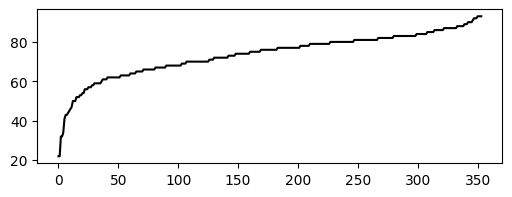

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import utils

def printRow(data,prefilter="RP",alphabet="majmin"):
    text = f"{prefilter} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def getFscoreResults(filepath,alphabet="majmin",printMetadata=False):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    # check if track_id's are matching 
                    track_list.append(subgrp.attrs.get("name"))
                    # f_scores.append((subgrp.attrs.get(f"{alphabet}_f"),subgrp.attrs.get("name")))
                    f_scores.append(subgrp.attrs.get(f"{alphabet}_f"))
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
print(f"----------Table of results------------")
rp_text = "RP &"
median_text = "Median &"
header = "distance & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    inner,track_list_a = getFscoreResults("../results/source_separation_drums",alphabet,True)
    corr,track_list = getFscoreResults("../results/correlation_median_drums.hdf5",alphabet)
    for x in track_list_a:
        if x not in track_list:
            print(x)
    printRow(inner,"inner product",alphabet)
    printRow(corr,"correlation",alphabet)
    print("\\midrule")
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        deltas.append([100*(x-y) for x,y in zip(inner[dset],corr[dset])])
    
    index_outliers = np.where(np.abs(deltas[-1]) > 10)[0]
    print(f"-----Outliers {alphabet}-------------")
    print(" Title   |  Inner  | Corr")
    for index in np.where(np.abs(deltas[-1]) > 20)[0]:
        print(track_list[index],inner["combined"][index],corr["combined"][index])
    # print sorted data
    index = np.argsort(inner["combined"])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(100*np.array(inner["combined"])[index],'k')
    ax.plot(100*np.array(corr["combined"])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,349)
    ax.set_xlabel("Track number")
    ax.set_ylim(0,100)
    ax.legend(["inner","corr"])
    fig.savefig(f"../latex/figures/corr_sorted_{alphabet}.png")
    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,deltas,xlabels)
    ax.set_ylabel("delta F-score in %")
    fig.savefig(f"../latex/figures/corr_delta_{alphabet}.png")
    print(f"Wilcoxon Test: combined dataset {alphabet}")
    (N,p,z,r) = utils.wilcoxonTest(deltas[-1])
    if p < 0.001:
        print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
    else:    
        print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")